In [254]:
import pandas as pd
import numpy as np
import os
from bs4 import BeautifulSoup
from selenium import webdriver
import matplotlib.pyplot as plt
import re
from rich import print
from rich.progress import track
import seaborn as sns
from sklearn.linear_model import Lasso, Ridge, ElasticNet,LassoCV,RidgeCV
from sklearn.model_selection import cross_val_score, train_test_split,KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from selenium.webdriver.common.keys import Keys
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [112]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [33]:
def get_url(search_term):#scrapping links from amazon us
    """Generate url with search term"""
    
    template = "https://www.amazon.com/s?k={}&rh=n%3A565108&dc&crid=3ESHP39B9W3KQ&qid=1639523575&rnid=2941120011&sprefix=lapt%2Caps%2C359&ref=sr_nr_n_1"
    search_term = search_term.replace(" ", "+")
    
    
    # Add search term to url
    url = template.format(search_term)
    
    # Add page query to the placeholder
    url += '&page={}'
    
    return url

def extract_record(item):
    """Extract and return data from single record"""
        
    # name and url
    atag = item.h2.a
    name = atag.text.strip()
    new_url = "http://www.amazon.com"+atag.get('href')
    
    
    
    res = [name, new_url]
    return res

def main(search_term, file_name): # File name should have .csv ending
    
    chromedriver = "C:\Program Files\Google\Chrome\Application\chromedriver"
    os.environ["webdriver.chrome.driver"] = chromedriver
    DRIVER = webdriver.Chrome(chromedriver)
    

    
    DATA = []
    URL = get_url(search_term)
    
    for page in range(1,60):
        DRIVER.get(URL.format(page))
        SOUP = BeautifulSoup(DRIVER.page_source, 'html.parser')
        RESULTS = SOUP.find_all('div', {'data-component-type': 's-search-result'})
        for item in RESULTS:
            RES = extract_record(item)
            if RES:
                DATA.append(RES)
    
    DRIVER.close()
    
    df = pd.DataFrame(DATA, columns = ['Name', 'URL'])
    df.to_csv(file_name, index=False)

In [16]:
main("laptop", "Amazon_Laptop_Links.csv")

In [26]:

def get_data(url_list:list)->pd.DataFrame:
    chromedriver = "C:\Program Files\Google\Chrome\Application\chromedriver"
    os.environ["webdriver.chrome.driver"] = chromedriver
    DRIVER = webdriver.Chrome(chromedriver)
    lst = list()
    
    for url in track(url_list, description='[green]Stealing in progress...'):
        DRIVER.get(url)
        SOUP = BeautifulSoup(DRIVER.page_source, 'html.parser')
        try:
            #Price
            if SOUP.find('table', id='productDetails_techSpec_section_2').find_all('tr')!= None:
                if SOUP.find('span', id='priceblock_ourprice').text.strip().replace(',', '').replace('$', '')!= None:
                    Price = float(SOUP.find('span', id='priceblock_ourprice').text.strip().replace(',', '').replace('$', ''))
                else:
                    pass
                
                #SUMMARY
                summary_table = SOUP.find('table', id='productDetails_techSpec_section_1').find_all('tr')
                summary_table_data = {x.find('th').text.strip().split('\u200e')[len(x.find('th').text.strip().split('\u200e'))-1]: x.find('td').text.strip().split('\u200e')[len(x.find('td').text.strip().split('\u200e'))-1] for x in summary_table}

                # OTHER DETAILS
                other_technical_details_table = SOUP.find('table', id='productDetails_techSpec_section_2').find_all('tr')
                other_technical_details_table_data = {x.find('th').text.strip().split('\u200e')[len(x.find('th').text.strip().split('\u200e'))-1]: x.find('td').text.strip().split('\u200e')[len(x.find('td').text.strip().split('\u200e'))-1] for x in other_technical_details_table}

                # Merge the two tables in one dictionary then append it to a list
                summary_table_data["Price"]=Price
                lst.append({**summary_table_data,**other_technical_details_table_data})
                
        except:
             print(url)
            
        
        
    return pd.DataFrame(lst)

In [18]:
df1=pd.read_csv("Amazon_Laptop_Links.csv")

In [28]:
df1=df1['URL']

In [ ]:
df=get_data(df1)

In [ ]:
df.to_csv('Data.csv')

In [146]:
df=pd.read_csv("Data.csv")

In [147]:
df= df.rename(columns={'Processor_Count':'Processor_Count_Cores','Standing screen display size': 'display_size','Max Screen Resolution':'Resolution','Hard Drive':'Hard_Drive','Average Battery Life (in hours)':'Battery_Life','Item Weight':'Weight','Processor Brand':'Processor_Brand','Processor Count':'Processor_Count','Flash Memory Size':'Hard_Drive_Size','Hard Drive Interface':'Hard_Drive_Type','Processor_Count':'Processor_Count_Cores'})

In [148]:
df=df.drop(columns=['Unnamed: 0', 'Card Description','Rear Webcam Resolution','Graphics Card Ram Size','Voltage','Package Dimensions','Manufacturer','ASIN','Date First Available','Number of USB 2.0 Ports','Computer Memory Type','Screen Resolution','Hardware Platform','Hard Drive Rotational Speed','National Stock Number','Power Source','Optical Drive Type','Product Dimensions','Operating System','Number of USB 3.0 Ports','Item model number','Series','Batteries','Wireless Type','Graphics Coprocessor','Memory Speed','Hard_Drive_Type','Hard_Drive_Size','Item Dimensions  LxWxH','Chipset Brand'])

In [149]:
df['display_size'] = df['display_size'].str.split(' ').str[0]
df['Processor'] = df['Processor'].str.split(' ').str[0]
df['RAM'] = df['RAM'].str.split(' ').str[0]
df['Hard_Drive'] = df['Hard_Drive'].str.split(' ').str[0]
df['Battery_Life'] = df['Battery_Life'].str.split(' ').str[0]
df['Weight'] = df['Weight'].str.split(' ').str[0]
df['Battery_Life'] = df['Battery_Life'].str.split('.').str[0]
df['Weight'] = df['Weight'].str.split('.').str[0]

In [150]:
#Cleanig Processor_Brand
# Intel 
df['Processor_Brand'] = df['Processor_Brand'].replace(['Unknown','Qualcomm','Intel Core i5-1145G7','10th Gen Intel Comet Lake Core i7-1065G7','Intel Core i7-1165G7','Intel Celeron Processor J4115','Intel Core i7-1185G7','NVIDIA','Allwinner','VIA','MedieTek','Mediatek'],'Intel')
# NVIDIA
df['Processor_Brand'] = df['Processor_Brand'].replace([''],'NVIDIA')
# AMD 
df['Processor_Brand'] = df['Processor_Brand'].replace(['AMD Ryzen 5 4600U','AMD Ryzen 5 3500C'],'AMD')

In [151]:
#Cleanig Processor
df['Processor'] = df['Processor'].replace(['1_2GHz_Cortex_A8'],1.2)
df['Processor'] = df['Processor'].replace(['pentium','1600','celeron'],1.6)
df['Processor'] = df['Processor'].replace(['amd_ryzen_7','apple_ci7','core_i7_family','core_i7'],5.1)
df['Processor'] = df['Processor'].replace(['apple_ci5','core_i5_8200y','core_i5_family','core_i5','8032'],4.2)
df['Processor'] = df['Processor'].replace(['32','3200','300','Xeon','core_i3'],3)

In [187]:
#Cleanig RAM
df['RAM'] = df['RAM'].replace(['LPDDR3','SDRAM',2],4)
df['RAM'] = df['RAM'].replace(['SO-DIMM','LPDDR4','DDR4',1,6,128,512,256,9],8)

In [192]:
#Cleanig Hard_Drive
df['Hard_Drive'] = df['Hard_Drive'].replace(['embedded',1024,'eMMC','flash','Embedded','emmc','flash_memory_solid_state'],64)
df['Hard_Drive'] = df['Hard_Drive'].replace([1152,100,192,8,'Flash',1],128)
df['Hard_Drive'] = df['Hard_Drive'].replace([1256,6,20,'PCIe','2556','No','ssd',2],256)
df['Hard_Drive'] = df['Hard_Drive'].replace(['hdd',1.5,'mechanical_hard_drive',1000],1000)
df['Hard_Drive'] = df['Hard_Drive'].replace(['512GB',750,628,52,1512,500,16,'SSD'],512)
df['Hard_Drive'] = df['Hard_Drive'].replace([4000,2000,4],2000)


In [154]:
#change to numeric 
df['display_size']=df['display_size'].apply(pd.to_numeric)
df['Processor']=df['Processor'].apply(pd.to_numeric)
df['RAM']=df['RAM'].apply(pd.to_numeric)
df['Hard_Drive']=df['Hard_Drive'].apply(pd.to_numeric)
df['Battery_Life']=df['Battery_Life'].apply(pd.to_numeric)
df['Weight']=df['Weight'].apply(pd.to_numeric)

In [155]:
#Cleanig Battery_Life
df['Battery_Life'] = df['Battery_Life'].replace([20.0,23.0,22.0,21.0,19.0],4)
df['Battery_Life'] = df['Battery_Life'].replace([47.0,60.0,39.0,465.0,25.0,45.0,42.0,2],10)
df['Battery_Life'] = df['Battery_Life'].replace([30.0,1.5,'mechanical_hard_drive',1000],5)
df['Battery_Life'] = df['Battery_Life'].replace([35.0,36.0,628,52,1512,500,16,'SSD'],6)
df['Battery_Life'] = df['Battery_Life'].replace([17.0,18.0,16.0,15.0,13.0],3)

In [158]:
#Cleanig Hard_Drive
df['Weight'] = df['Weight'].replace([0.0,14.0,12.0,19.0],4)

In [162]:
#Cleanig display_size
df['display_size'] = df['display_size'].replace([11.5,11.4],11.6)
df['display_size'] = df['display_size'].replace([10.3,0.1],10.1)
df['display_size'] = df['display_size'].replace([8.9],7)
df['display_size'] = df['display_size'].replace([13.9,3.0,13.0,13.4,13.5],13.3)
df['display_size'] = df['display_size'].replace([12.0,12.2,12.5],12.5)
df['display_size'] = df['display_size'].replace([14.1,16.0],14)
df['display_size'] = df['display_size'].replace([17.0,17.3],17.3)
df['display_size'] = df['display_size'].replace([15.0,15.6],15.6)

In [174]:
df['Resolution'] = df['Resolution'].replace(['1366x768 Pixels','1366x768','1366X768 Pixels','1366 x 768 MP','HD Display','1366 x 768 Lines Per Inch','1366*768 Pixels','HD (1366 x 768) Touchscreen Pixels','1366X768 pixels','1366X768 pixels','1368x766 Pixels','1366 X 768','1366x768 MP','1361 x 768 Pixels','1366x766 Pixels','1366 X 768 MP','1366 x 768 HD Pixels','HD (1366 x 768) SVA Pixels','1366×768 Pixels','HD ( 1366 x 768 )','HD (1366 x 768) Pixels','1366 Pixels','1366*768 pixels','1366 x 768','1366 x 912 Pixels','1366 x 912 MP'],'1366x768 Pixels')
df['Resolution'] = df['Resolution'].replace(['3200 x 1800 pixels','4096x2304 Pixels','3840x2160','3840 x 2160 Pixels','3840 x 2400','4K UHD (3840 x 2160)','3840X2160 Pixels'],'2160 X 1440 Pixels')
df['Resolution'] = df['Resolution'].replace(['2560x1600 Pixels','2160 X 1440 Pixels','2560 x 1440 Pixels','2560 x 1600 Pixels','2560 x 1440','2560x1440 Pixels','2160 x 1350 Pixels','2048 x 1536','2048 x 1536','2256 x 1504','2160x1440 Pixels','2160*1440 Pixels','2560 x 1600 Lines Per Inch','2666 Pixels','2496 x 1664','2560 x 1600','2256 x 1504 Pixels','4096 x 2304 Pixels'],'2K')
df['Resolution'] = df['Resolution'].replace(['1600 x 900 Pixels','1,600 x 900 Pixels','HD+ Display','1600 x 900 Lines Per Inch','1600x900 MP','HD+ (1600 x 900) Pixels','1600 x 900 Pixels'],'1600 x 900 Pixels')
df['Resolution'] = df['Resolution'].replace(['3840 x 2160','3840 x 2400 Pixels','3000 x 2000 Pixels','4096×2304 @24Hz Lines Per Inch','3240 x 2160','3200 x 1800 Pixels','4K Lines Per Inch','3200X1800 pixels','3300 x 2200 Pixels','3840 x 2160','3840 x 2160','3840 x 2400 Pixels','3000 x 2000 Pixels','4096×2304 @24Hz Lines Per Inch','3240 x 2160'],'4K')
df['Resolution'] = df['Resolution'].replace(['1920 X 1200 Pixels','1920 x 1200','1900*1200 Pixels','1920x1200 Pixels','1920X1200 Pixels','1920*1200 Pixels','1920 X 1200 Pixels'],'1920 X 1200 Pixels')
df['Resolution'] = df['Resolution'].replace(['1600 x 900','1600x900','1600x900 Pixels','1600 x 900 Pixels'],'1600 x 900 Pixels')
df['Resolution'] = df['Resolution'].replace(['1280*800 Pixels','1280×720 Pixels','1280 x 800','1280*800 MP','1280×720 Pixels','1280 x 720 Pixels','1280 x 720','1280×720 Pixels','1280 X 800 Pixels'],'1280×720 Pixels')
df['Resolution'] = df['Resolution'].replace(['800*1280 Pixels','1024*600 Pixels','1024 Lines Per Inch'],'1024*600')
df['Resolution'] = df['Resolution'].replace(['1920 X 1200 Pixels','1920 x 1200 Pixels'],'1920 x 1200 Pixels')
df['Resolution'] = df['Resolution'].replace(['1366x768 Pixels','1366 x 768 Pixels'],'1366 x 768 Pixels')
df['Resolution'] = df['Resolution'].replace(['1920x1080 Pixels','1920 x 1080','1920x1080','1920 x 1080 MP','19201080 Pixels','1920X1080 Pixels','1920 X 1080 Pixels','1920 x 1080 Lines Per Inch','1920x1080 Lines Per Inch','19201080 Lines Per Inch','FHD (1920 x 1080) IPS 144Hz Pixels','1920x1080 MP','Full HD (1920 x 1080) IPS 144Hz Pixels','Full HD (1920 x 1080) 144Hz IPS','1920×1080 Pixels','1920 * 1080 Pixels','1,920x1,080 Pixels','FHD (1920 x 1080) IPS Pixels','FHD (1920 x 1080) WVA 120Hz Pixels','1921 x 1080 Pixels','FHD (1920x1080) IPS 144Hz Pixels','Full HD(1920 x 1080) Anti-glare Pixels','Full HD (1920 x 1080)','1920 x 1080 (Full HD)','1080p Full HD Pixels','1080 Pixels','1290 x 1080','1920*1080 Lines Per Inch','FHD Display','1920*1080 Pixels','1920x1080 Pixels','1920 x 1080','1920x1080','1920 x 1080 MP','19201080 Pixels','1920X1080 Pixels','1920 X 1080 Pixels','1920 x 1080 Lines Per Inch','1920x1080 Lines Per Inch','19201080 Lines Per Inch','FHD (1920 x 1080) IPS 144Hz Pixels','1920x1080 MP','Full HD (1920 x 1080) IPS 144Hz Pixels','Full HD (1920 x 1080) 144Hz IPS','1920×1080 Pixels','1920 * 1080 Pixels','1,920x1,080 Pixels','FHD (1920 x 1080) IPS Pixels','FHD (1920 x 1080) WVA 120Hz Pixels','1921 x 1080 Pixels','FHD (1920x1080) IPS 144Hz Pixels','Full HD(1920 x 1080) Anti-glare Pixels','Full HD (1920 x 1080)','1920 x 1080 (Full HD)'],'1920 x 1080 Pixels')

In [241]:
# Color
m = df['Color'].str.contains('Gray', na=False)
df.loc[m,'Color'] = 'Gray'
m = df['Color'].str.contains('Gery', na=False)
df.loc[m,'Color'] = 'Gray'
m = df['Color'].str.contains('Grey', na=False)
df.loc[m,'Color'] = 'Gray'
m = df['Color'].str.contains('grey', na=False)
df.loc[m,'Color'] = 'Gray'
m = df['Color'].str.contains('Black', na=False)
df.loc[m,'Color'] = 'Black'
m = df['Color'].str.contains('Blue', na=False)
df.loc[m,'Color'] = 'Blue'
m = df['Color'].str.contains('Silver', na=False)
df.loc[m,'Color'] = 'Silver'
m = df['Color'].str.contains('Gold', na=False)
df.loc[m,'Color'] = 'Gold' 
m = df['Color'].str.contains('White', na=False)
df.loc[m,'Color'] = 'White'
m = df['Color'].str.contains('Red', na=False)
df.loc[m,'Color'] = 'Red'
m = df['Color'].str.contains('Sliver', na=False)
df.loc[m,'Color'] = 'Silver'
m = df['Color'].str.contains('gold', na=False)
df.loc[m,'Color'] = 'Gold'
df['Color'] = df['Color'].replace(['GTX 1660 Ti','Windows 10 Pro','4G','Dark blue','Core-i5','Machined Aluminum','Jet black','Electro Punk','灰色','SLIVER','黑色','Intel Celeron N4020','Non-Touchscreen','AORUS 15G - Alloy + Mech Keyboard','Dark Orchid','BLACK, GREEN','Navy','Snowflake white','Citrus Soda Yellow','Non-Touch | i3-7130U | 128GB SSD','Light Titan','Forest teal with matte finish','Carbon Fiber','15 inch FHD','Bronze','15.6" | AERO 15 | TOP SELLER','Y13Pro/13.3inch','Dune','M16-i9-11900H-RTX 3060-16G/1T','Core black','Natural silver','NEW','Flaming Copper','银色','Forest Teal','Sandstorm','Platinum Titan','Purple','Green','Rose Pink','Sand'],'Black')

In [239]:
df['display_size'].fillna(value=14.0, inplace=True)
df['Resolution'].fillna(value='2K', inplace=True,limit=50)
df['Resolution'].fillna(value='4K', inplace=True,limit=50)
df['Processor'].fillna(value=3.6, inplace=True)
df['RAM'].fillna(value=16, inplace=True)
df['Hard_Drive'].fillna(value=256, inplace=True)
df['Battery_Life'].fillna(value=7, inplace=True,limit=200)
df['Battery_Life'].fillna(value=5, inplace=True,limit=200)
df['Battery_Life'].fillna(value=6, inplace=True,limit=300)
df['Battery_Life'].fillna(value=8, inplace=True,limit=200)
df['Battery_Life'].fillna(value=3, inplace=True,limit=200)
df['Battery_Life'].fillna(value=4, inplace=True,limit=200)
df['Battery_Life'].fillna(value=12, inplace=True,limit=100)
df['Battery_Life'].fillna(value=9, inplace=True,limit=100)
df['Battery_Life'].fillna(value=1, inplace=True,limit=100)
df['Weight'].fillna(value=7, inplace=True)
df['Weight'].fillna(value=7, inplace=True)

In [244]:
df['Color'].fillna(value='Silver', inplace=True,limit=100)
df['Color'].fillna(value='Gray', inplace=True,limit=100)
df['Color'].fillna(value='Blue', inplace=True,limit=100)
df['Color'].fillna(value='White', inplace=True,limit=200)
df['Color'].fillna(value='Gold', inplace=True,limit=200)


In [249]:
df['Processor_Brand'].fillna(value='Intel', inplace=True)
df['Processor_Count'].fillna(value=2, inplace=True)


In [245]:
# Count RAM
pd.DataFrame(df['Color'].value_counts(ascending=True))

,Color
Beige Mousse,4
Mica,5
Almond,6
Pink,12
Red,13
Blue,160
Gold,227
White,239
Gray,308
Silver,373


In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   display_size     1782 non-null   float64
 1   Resolution       1782 non-null   object 
 2   Processor        1782 non-null   float64
 3   RAM              1782 non-null   float64
 4   Hard_Drive       1782 non-null   float64
 5   Battery_Life     1782 non-null   float64
 6   Price            1782 non-null   float64
 7   Brand            1782 non-null   object 
 8   Weight           1782 non-null   float64
 9   Color            1782 non-null   object 
 10  Processor_Brand  1782 non-null   object 
 11  Processor_Count  1782 non-null   float64
dtypes: float64(8), object(4)
memory usage: 167.2+ KB


In [251]:
df

,display_size,Resolution,Processor,RAM,Hard_Drive,Battery_Life,Price,Brand,Weight,Color,Processor_Brand,Processor_Count
0,15.6,1920 x 1080 Pixels,3.50,4.0,128.0,10.0,395.34,Acer,3.0,Silver,AMD,4.0
1,15.6,1920 x 1080 Pixels,4.50,8.0,512.0,11.0,812.80,Acer,5.0,Black,Intel,4.0
2,15.6,1920 x 1080 Pixels,4.20,8.0,512.0,8.0,555.00,HP,3.0,Silver,Intel,4.0
3,15.6,1920 x 1080 Pixels,4.70,16.0,512.0,8.0,1199.00,HP,3.0,Silver,Intel,4.0
4,17.3,1600 x 900 Pixels,4.20,8.0,512.0,8.0,630.00,HP,4.0,Silver,Intel,4.0
5,15.6,1920 x 1080 Pixels,4.10,4.0,128.0,7.0,398.55,Acer,4.0,Silver,Intel,2.0
6,15.6,1920 x 1080 Pixels,2.60,16.0,128.0,7.0,649.00,HP,3.0,Silver,AMD,2.0
7,15.6,1366 x 768 Pixels,1.10,16.0,128.0,7.0,589.00,Dell,4.0,Black,Intel,4.0
8,11.6,1920 x 1080 Pixels,1.10,4.0,64.0,12.0,233.48,HP,2.0,Blue,Intel,2.0
9,14.0,1366 x 768 Pixels,2.60,8.0,256.0,7.0,439.00,HP,3.0,Blue,AMD,2.0


In [256]:
df.to_csv('Data_Cleaned.csv')

In [257]:
df = pd.get_dummies(df, columns=['Resolution','Brand','Color','Processor_Brand'])

In [258]:
df_train, df_val = train_test_split(df, test_size=0.25, random_state=3)

In [264]:
m = LinearRegression()
m.fit(df_train[['display_size','Processor','RAM','Hard_Drive','Battery_Life','Weight','Processor_Count','Resolution_2K','Resolution_1920 x 1080 Pixels','Brand_Acer','Color_Black','Processor_Brand_Intel','Resolution_4K','Resolution_1366 x 768 Pixels']],df_train['Price'])
m.score(df_train[['display_size','Processor','RAM','Hard_Drive','Battery_Life','Weight','Processor_Count','Resolution_2K','Resolution_1920 x 1080 Pixels','Brand_Acer','Color_Black','Processor_Brand_Intel','Resolution_4K','Resolution_1366 x 768 Pixels']],df_train['Price'])

0.570972140974866

In [265]:
m.score(df_val[['display_size','Processor','RAM','Hard_Drive','Battery_Life','Weight','Processor_Count','Resolution_2K','Resolution_1920 x 1080 Pixels','Brand_Acer','Color_Black','Processor_Brand_Intel','Resolution_4K','Resolution_1366 x 768 Pixels']],df_val['Price'])

0.5921335844446709

In [266]:
m.intercept_

-484.23689083015836

In [268]:
X = df[['Brand_Dell','Processor','RAM','Battery_Life','Hard_Drive']]
y = df['Price']

In [269]:
m.fit(X,y)

LinearRegression()

In [270]:
ypred_P=m.predict(X)
ypred_P

array([ 594.47570351,  948.33417139,  927.57541916, ...,  769.57919046,
       1644.55285806,  731.03542857])

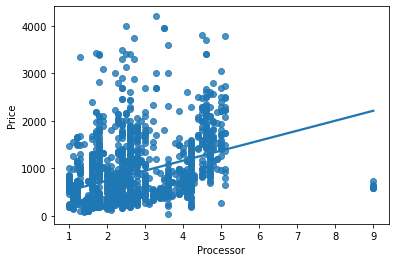

In [272]:
sns.regplot(x="Processor", y="Price",ci=None, data=df);

In [273]:
(m.intercept_)+m.coef_[0]+m.coef_[1]*2+m.coef_[2]*8+m.coef_[3]*10+m.coef_[4]*1000

884.181387544191

In [275]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [276]:
r_sqr=r2_score(y,ypred_P)
r_sqr

0.49074298170437836

In [277]:
mse1 = mean_squared_error(y, ypred_P, squared=True)
rmse1 = mean_squared_error(y, ypred_P, squared=False)
mae1 = mean_absolute_error(y, ypred_P)
r_sqr=r2_score(y,ypred_P)

In [278]:
print('Mean Square Error = ', mse1)
print ('Root Mean Square Error =', rmse1)
print ('Mean Absoluter Error=', mae1)
print ('r_sqr = ', r_sqr)

Mean Square Error =  215243.72989803067

Root Mean Square Error = 463.94367103995575

Mean Absoluter Error= 314.271078981954

r_sqr =  0.49074298170437836

In [279]:
def linear_regression_score(X, y, kfold:int=5, scoring_type:str='r2'):
    lm = LinearRegression()
    result = cross_val_score(lm, X, y, cv=kfold, scoring=scoring_type)
    return np.mean(result)

def lasso_score(X, y, X_val,y_val ,kfold:int=5, scoring_type:str='r2'):
    alphas = 10**np.linspace(6,-2,50)*0.5
    lasso = Lasso(max_iter=10000, normalize=True)
    
    lassocv = LassoCV(alphas=None, cv=kfold, max_iter=100000, normalize=True)
    lassocv.fit(X_val, y_val)
    lasso.set_params(alpha=lassocv.alpha_)
    clf = Lasso(alpha=lassocv.alpha_)
    scores = cross_val_score(clf, X, y, cv=kfold)
    return scores.mean()
    
def riggid_score(X,y,X_val,y_val,kfold:int=5):
    alphas = 10**np.linspace(6,-2,50)*0.5
    ridgecv = RidgeCV(alphas=alphas, normalize=True)
    ridgecv.fit(X_val, y_val)
    ridge6 = Ridge(alpha=ridgecv.alpha_, normalize=True)
    ridge6.fit(X, y)
    score = cross_val_score(ridge6, X, y, cv=kfold)
    return score.mean()
    
def poly_score(X,y,X_val,y_val,degree:int=2,kfold:int=5):
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X_val)
    poly = LinearRegression()
    return np.mean(cross_val_score(poly, X_poly, y_val, cv=kfold))

In [280]:
def find_scores(df, target:str):
#     kfold = KFold(n_splits=20, shuffle=True, random_state=0)
    X, X_test, y, y_test = train_test_split(df.loc[:, df.columns != target], df[target], test_size=0.25, random_state=64)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=64)
    linear_score = linear_regression_score(X_train, y_train)
    lassov_score = lasso_score(X_train, y_train,X_val,y_val,kfold=10)
    riggidv_score = riggid_score(X_train, y_train,X_val,y_val,kfold=10)
    polyv_score = poly_score(X_train, y_train,X_val,y_val,degree=2,kfold=10)
    return {'Linear Score':linear_score,'Lasso Score':lassov_score,'Ridge Score':riggidv_score,'Polynomial Score':polyv_score}

In [281]:
find_scores(df, 'Price')

{'Linear Score': -1.657635061629825e+16,
 'Lasso Score': 0.6027674344211563,
 'Ridge Score': 0.604255855974386,
 'Polynomial Score': -487825348410.27264}